# Visualização de arquivos netCDF

### Importando pacotes

In [1]:
import warnings
warnings.filterwarnings("ignore")

import netCDF4 as nc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as bm
import matplotlib.dates as mdates
import os

### Verificando Tamanho do arquivo 

In [2]:
size = os.stat('/home/torvizz/vento10m_2014.nc').st_size / 1e9
print('%.2f GB' % size)

50.06 GB


### Importar _Dataset_ deste tamanho não é viável
### Executar módulos da clase _Dataset_ para recuperar partes do arquivo de interesse

#### Não funcionará como normalmente:
ncObj = nc.Dataset('caminho')<br>
var = ncObj.variables['var'][ : ]<br>
série = var[t_inicial : t_final, x_inicial : x_final, y_inicial : y_final]

#### Alternativa:
var = nc.Dataset('caminho').variables['var'][t_inicial : t_final, x_inicial : x_final, y_inicial : y_final]
#### Dessa forma só a parte de interesse é carregada

In [3]:
nc.Dataset('/home/torvizz/vento10m_2014.nc').variables

OrderedDict([(u'time', <type 'netCDF4._netCDF4.Variable'>
              float64 time(time)
                  units: hours since 2014-1-1 0
              unlimited dimensions: time
              current shape = (8760,)
              filling on, default _FillValue of 9.96920996839e+36 used),
             (u'longitude', <type 'netCDF4._netCDF4.Variable'>
              float64 longitude(longitude)
                  units: degrees_east
                  long_name: Longitude
              unlimited dimensions: 
              current shape = (701,)
              filling on, default _FillValue of 9.96920996839e+36 used),
             (u'latitude', <type 'netCDF4._netCDF4.Variable'>
              float64 latitude(latitude)
                  units: degrees_north
                  long_name: Latitude
              unlimited dimensions: 
              current shape = (1019,)
              filling on, default _FillValue of 9.96920996839e+36 used),
             (u'u10mj', <type 'netCDF4._netCDF4.Var

### Plotando _grid_ do tempo 0

In [4]:
u1 = nc.Dataset('/home/torvizz/vento10m_2014.nc').variables['u10mj'][0]
v1 = nc.Dataset('/home/torvizz/vento10m_2014.nc').variables['v10mj'][0]
w1 = (u1**2+v1**2)**0.5
lat = nc.Dataset('/home/torvizz/vento10m_2014.nc').variables['latitude'][:]
lon = nc.Dataset('/home/torvizz/vento10m_2014.nc').variables['longitude'][:]

#### Método imshow

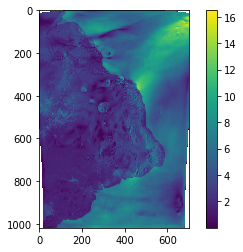

In [5]:
f, ax = plt.subplots()
plot = ax.imshow(w1)
f.colorbar(plot, ax=ax)

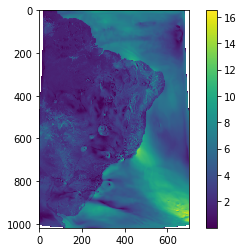

In [6]:
f, ax = plt.subplots()
plot = ax.imshow(w1[::-1])
f.colorbar(plot, ax=ax)

#### Método contourf

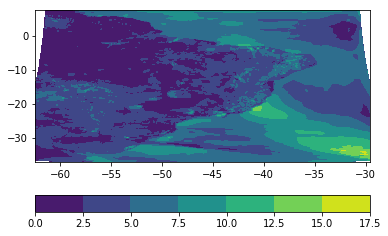

In [7]:
xx, yy = np.meshgrid(lon, lat)# grades 2d das arrays 1d de lat e lon

f, ax = plt.subplots()
plot = ax.contourf(xx,yy,w1)
f.colorbar(plot, ax=ax, orientation='horizontal')
# mp.pcolor(xx,yy,u1)

#### Plotando escolhendo projeção com a clase Basemap 

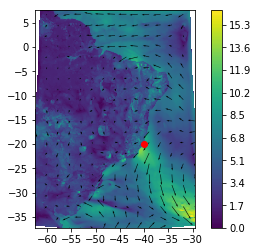

In [8]:
% matplotlib inline
f, ax = plt.subplots()

lims = (lon[0],lon[-1], lat[0], lat[-1])
mp = bm(projection='cyl', llcrnrlat=lims[2], urcrnrlat=lims[3],
                llcrnrlon=lims[0], urcrnrlon=lims[1], resolution='l',ax=ax)

#       lat, lon e venteo grids  Array para setar o minimo, máximo e resolução 
#                  |  |  |                               da renderização de z
#                  x  y  z             min       max    intervalo
cont = mp.contourf(xx,yy,w1,np.arange(w1.min(),w1.max(),0.1))

ax.set_xticks(range(-60,-29,5)) #escolha das latitudes a serem mostradas
ax.set_yticks(range(-35,6,5)) #escolha das longitudes a serem mostradas
f.colorbar(cont, ax=ax)

plt.plot(-40,-20,'ro')
# plotando vetores com espaçamente de 50 pixeis entre eles
ax.quiver(xx[::50,::50],yy[::50,::50],u1[::50,::50],v1[::50,::50])

### Série temporal
#### coordenadas com click

In [9]:
# não funciona no jupyter notebokk, melhor utilizando no terminal ou ima IDE como Spyder

# [(x,y)] = plt.ginput()

#### função para recuperar índices

In [10]:
def latLon2ix(lat, lon, lat_ul, lon_ul, lat_res, lon_res=None):
    if lon_res==None:
        lon_res=lat_res
    x = np.rint(np.abs(lat - lat_ul)/lat_res)
    y = np.rint(np.abs(lon - lon_ul)/lon_res)
    return x, y

#### recuperando índices da longitude -40 e da latitude -20

In [11]:
x_ix, y_ix = latLon2ix(-20, -40, lat[0], lon[0], lat[1]-lat[0], lon[1]-lon[0])

#### confirmando se os índices foram gerados corretamente 

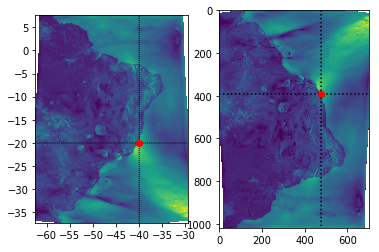

In [12]:
f, (ax1,ax2) = plt.subplots(1,2)

lims = (lon[0],lon[-1], lat[0], lat[-1])
mp = bm(projection='cyl', llcrnrlat=lims[2], urcrnrlat=lims[3],
                llcrnrlon=lims[0], urcrnrlon=lims[1], resolution='l',ax=ax1)

mp.contourf(xx,yy,w1,np.arange(w1.min(),w1.max(),0.1))
mp.drawmeridians([-40])
mp.drawparallels([-20])
ax1.set_xticks(range(-60,-29,5)) 
ax1.set_yticks(range(-35,6,5)) 
ax1.plot(-40,-20,'ro')

ax2.imshow(w1)
ax2.plot(range(w1.shape[1]), np.repeat(x_ix, w1.shape[1]),'k:')
ax2.plot(np.repeat(y_ix, w1.shape[0]), range(w1.shape[0]),'k:')
ax2.plot(y_ix,x_ix,'ro') # posição de x e y invertidas já que numa matriz o x 
                        # representa a latitude e o y a longitude

#### Carregando dados da série temporal de _U_ e *V* do ponto escolhido

In [13]:
u = nc.Dataset('/home/torvizz/vento10m_2014.nc').variables['u10mj'][:,x_ix,y_ix]

In [14]:
v = nc.Dataset('/home/torvizz/vento10m_2014.nc').variables['v10mj'][:,x_ix,y_ix]

In [15]:
time = nc.Dataset('/home/torvizz/vento10m_2014.nc').variables['time'][:]

#### convertendo _timedeltas_ para _timestamps_ dentro de um objeto de índice temporal da biblioteca Pandas

In [16]:
tIndex = pd.to_datetime(time, unit='h', origin='2014-01-01')

In [17]:
time

masked_array(data=[0.0, 1.0, 2.0, ..., 8757.0, 8758.0, 8759.0],
             mask=[False, False, False, ..., False, False, False],
       fill_value=9.969209968386869e+36)

In [18]:
tIndex

DatetimeIndex(['2014-01-01 00:00:00', '2014-01-01 01:00:00',
               '2014-01-01 02:00:00', '2014-01-01 03:00:00',
               '2014-01-01 04:00:00', '2014-01-01 05:00:00',
               '2014-01-01 06:00:00', '2014-01-01 07:00:00',
               '2014-01-01 08:00:00', '2014-01-01 09:00:00',
               ...
               '2014-12-31 14:00:00', '2014-12-31 15:00:00',
               '2014-12-31 16:00:00', '2014-12-31 17:00:00',
               '2014-12-31 18:00:00', '2014-12-31 19:00:00',
               '2014-12-31 20:00:00', '2014-12-31 21:00:00',
               '2014-12-31 22:00:00', '2014-12-31 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq=None)

#### Alocando dados em uma Pandas DataFrame (tipo de objeto ideal para se armazenar tabelas)

In [19]:
wdf = pd.DataFrame(np.vstack([u,v]).T, index=tIndex, columns=['u','v'])

In [20]:
wdf.head() #visualização das 5 primeiras linhas

,u,v
2014-01-01 00:00:00,-4.521710,-8.799084
2014-01-01 01:00:00,-4.032815,-8.881084
2014-01-01 02:00:00,-3.428720,-9.144959
2014-01-01 03:00:00,-2.722991,-9.199640
2014-01-01 04:00:00,-1.838515,-8.682140


#### Recuperando a média diária dos dados

In [21]:
wdf_dm = wdf.resample('D').mean()

In [22]:
wdf_dm.head()

,u,v
2014-01-01,-2.683600,-7.889532
2014-01-02,-2.688326,-7.501848
2014-01-03,-3.214466,-6.486873
2014-01-04,-3.126823,-6.051680
2014-01-05,-3.194350,-3.902935


#### Recuperando e plotando série de velocidades

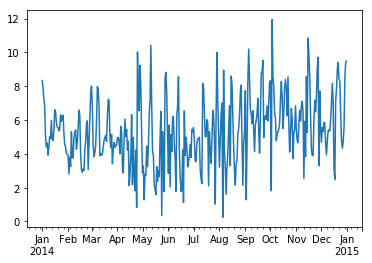

In [23]:
ws = (wdf_dm.u**2+wdf_dm.v**2)**0.5

ws.plot()

#### Criando _timedeltas_ para plotar e formatar _ticks_ do eixo do tempo no _plot_ da biblioteca Matplotlib

In [24]:
xIndex = mdates.date2num(wdf_dm.index)

#### Plotando _stickplot_

(array([735234., 735265., 735293., 735324., 735354., 735385., 735415.,
        735446., 735477., 735507., 735538., 735568., 735599.]),
 <a list of 13 Text xticklabel objects>)

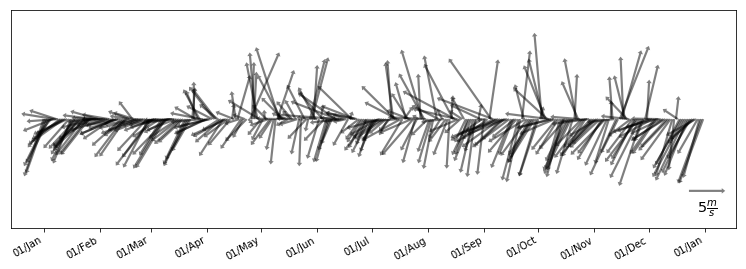

In [26]:
f, ax = plt.subplots(figsize=(13,4))# gerando figura

# plotando série de vetores
qw = ax.quiver(xIndex,np.zeros(len(wdf_dm)),wdf_dm.u.values,wdf_dm.v.values,
            alpha=0.5, width=0.003, scale= 100,
            headlength=1.6, headaxislength=1.6, headwidth=2.5)

# plotando escala do tamanho das setas
ax.quiverkey(qw, 0.96, 0.17, 5, r'$5 \frac{m}{s}$', labelpos='S',
                 fontproperties = dict(size='x-large', style= 'italic'))

# formatando rótulos (ticklabels) das posições no tempo referentes ao eixo x (ticks)
dFmt = mdates.DateFormatter('%d/%b') # formato de exibição dos labels
                                     # a partir de caracteres especiais
ax.set_yticks([])# suprimindo as ticks do eixo y
ax.xaxis_date()# esplicitando que o eixo x se refere à tempo
ax.xaxis.set_major_locator(mdates.DayLocator(1))# escolhendo dias á serem mostrados
ax.xaxis.set_major_formatter(dFmt)# formatando labels a partir do formato gerado
plt.xticks(rotation=30, ha='right')# rotacionando ticklabels e alinhando-as com as ticks
# f.savefig('caminho.estensão')# salvando figura no diretório e com estensão explicitados